In [1]:
import sys
sys.executable

'K:\\Anaconda3\\envs\\efficientdet-pytorch\\python.exe'

In [2]:
import torch
import os
from datetime import datetime
import time
import math
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
SEED = 42
img_scale=768
box_scale=768

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

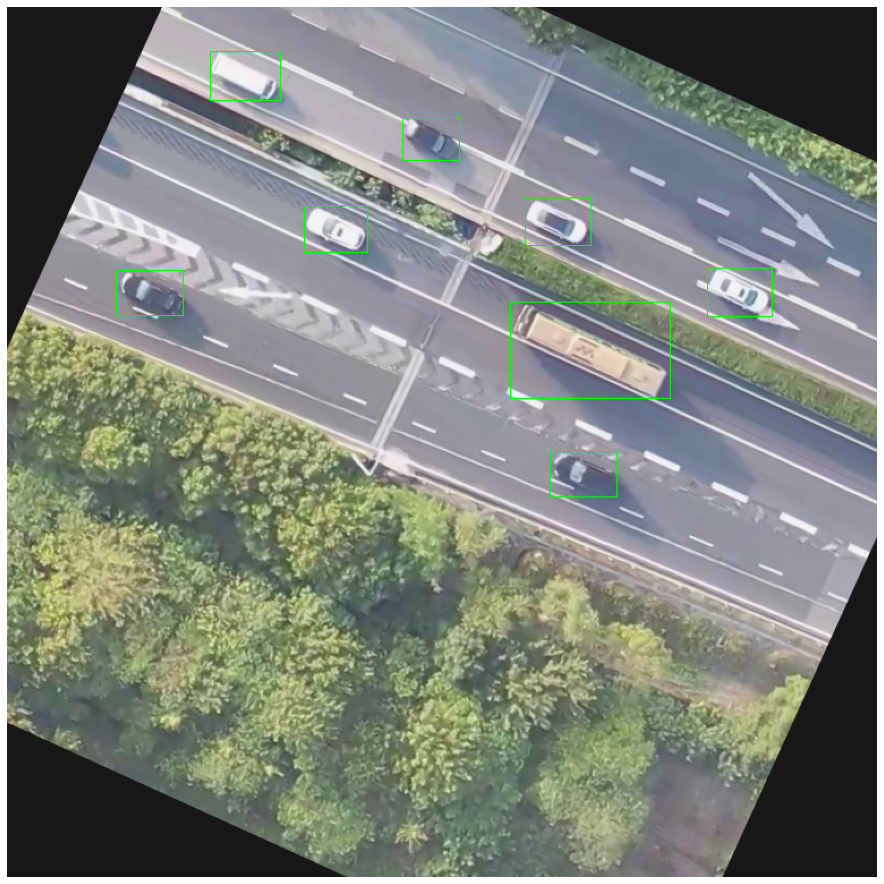

In [8]:
def obb_to_aabb(bbox, **kwargs):
    a = bbox[4] / 180 * 3.14159265
    x = (bbox[0] + bbox[2]) * 0.5
    y = (bbox[1] + bbox[3]) * 0.5
    length = bbox[2] - bbox[0]
    width = bbox[3] - bbox[1]
    c = math.cos(a)
    s = math.sin(a)
    
    xx1 = x + c * length * 0.5 - s * width * 0.5
    yy1 = y + s * length * 0.5 + c * width * 0.5
    
    xx2 = x + c * length * 0.5 + s * width * 0.5
    yy2 = y + s * length * 0.5 - c * width * 0.5
    
    xx3 = x - c * length * 0.5 - s * width * 0.5
    yy3 = y - s * length * 0.5 + c * width * 0.5
    
    xx4 = x - c * length * 0.5 + s * width * 0.5
    yy4 = y - s * length * 0.5 - c * width * 0.5
    bbox2 = (min(xx1, xx2, xx3, xx4), min(yy1, yy2, yy3, yy4), max(xx1, xx2, xx3, xx4), max(yy1, yy2, yy3, yy4))
    return bbox2


def get_train_transforms():
    return A.Compose(
        [
            A.Rotate(border_mode=cv2.BORDER_CONSTANT, value=(0,0,0), use_obb=True, p=0.5),
            A.Lambda(bbox=obb_to_aabb, always_apply=True, use_obb=True, p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_train_transforms2():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
            ],p=0.9),
            #A.GaussianBlur(always_apply=True, p=1.0),
            #A.ChannelShuffle(p=1.0),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Resize(height=img_scale, width=img_scale, p=1.0),
            #A.Cutout(num_holes=4, max_h_size=32, max_w_size=32, fill_value=0, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Lambda(bbox=obb_to_aabb, always_apply=True, use_obb=True, p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )
def get_valid_transforms2():
    return A.Compose(
        [
            A.Resize(height=img_scale, width=img_scale, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

class DatasetRetriever(Dataset):
    def __init__(self, root, transform=None, transform2=None, test=False):
        super(DatasetRetriever, self).__init__()
        if isinstance(root, torch._six.string_classes):
            root = os.path.expanduser(root)
        self.root = root
        self.transform = transform
        self.transform2 = transform2
        data_path = os.path.join(root, "obj")
        if test:
            list_path = os.path.join(root, "test.txt")
        else:
            list_path = os.path.join(root, "train.txt")
        with open(list_path) as f1:
            lines = f1.readlines()
            lines = [line.replace("\n", "") for line in lines]
        self.img_ids = list(range(len(lines)))
        self.img_names = list(lines)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        path = os.path.join(self.root,  self.img_names[index])
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0        

        with open(path.replace(".jpg", ".txt")) as f:
            lines = f.readlines()
        boxes = []
        for line in lines:
            values = [float(token) for token in line.replace("\n", "").split(" ")]
            bbox = [(values[1]-values[3]*0.5)*box_scale, (values[2]-values[4]*0.5)*box_scale,
                    (values[1]+values[3]*0.5)*box_scale, (values[2]+values[4]*0.5)*box_scale, values[5]+360.0 if values[5] < 0 else values[5]]
            boxes.append(bbox)
            
        boxes = torch.tensor(boxes, dtype=torch.float32)
        boxes = torch.min(boxes, torch.tensor([float(box_scale)]))
        boxes = torch.max(boxes, torch.tensor([0.0]))
        
        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transform:
            for i in range(10):
                sample = self.transform(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels,
                    'use_obb': True
                })
                sample = self.transform2(**{
                    'image': sample['image'],
                    'bboxes': sample['bboxes'],
                    'labels': sample['labels'],
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    #yxyx: be warning
                    #print(target['boxes'])
                    #print(target['boxes'].shape)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]
                    #print(target['boxes'].shape)
                    target['labels'] = torch.stack(sample['labels']) # <--- add this!
                    #print(target['boxes'].shape, target['labels'].shape)
                    #assert len(sample['bboxes']) == labels.shape[0], 'not equal!'
                    break

        return image, target, img_id

    def __len__(self):
        return len(self.img_ids)
        
    def get_img(self, index):
        img_id = self.img_ids[index]
        path = os.path.join(self.root,  self.img_names[index])
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

train_dataset = DatasetRetriever("drone", transform=get_train_transforms(), transform2=get_train_transforms2(), test=False)
validation_dataset = DatasetRetriever("drone", transform=get_valid_transforms(), transform2=get_train_transforms2(), test=True)

image, target, image_id = train_dataset[2]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(32, 16))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 1)
    
ax.set_axis_off()
ax.imshow(numpy_image);

2499
625


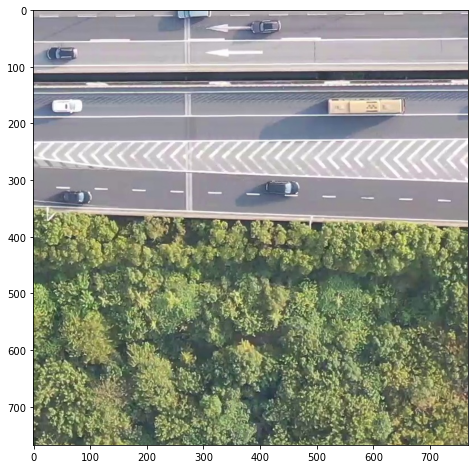

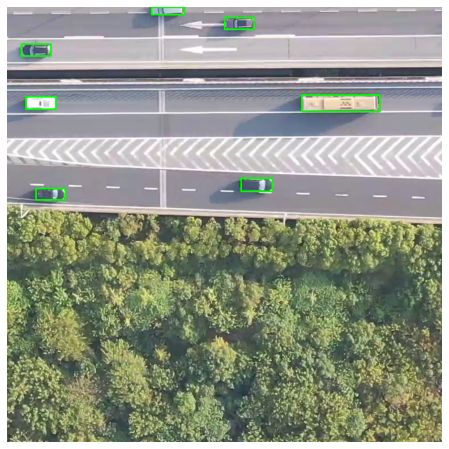

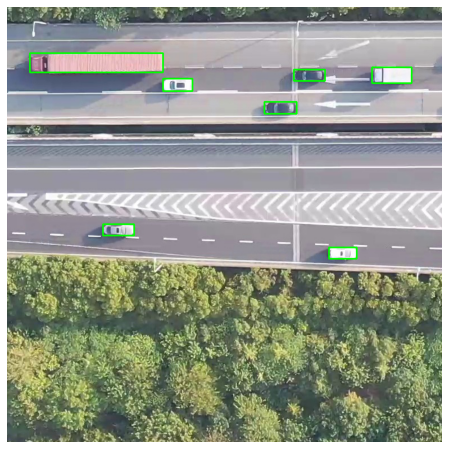

In [10]:
d = DatasetRetriever("drone")
print(len(d))
dd = DatasetRetriever("drone", test=True)
print(len(dd))
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(d.get_img(0))       
for i, (img, target, img_id) in enumerate(d):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box in target["boxes"]:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 1, 0), 2)
    ax.set_axis_off()
    ax.imshow(img);
    if i == 1:
        break

In [11]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                #for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                #    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

                outputs = self.model(images, target_res)
                loss = outputs['loss']
                
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res = {}
            target_res['bbox'] = boxes
            target_res['cls'] = labels 
            target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
            target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

            self.optimizer.zero_grad()
            
            outputs = self.model(images, target_res)
            loss = outputs['loss']
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [12]:
class TrainGlobalConfig:
    num_workers = 0
    batch_size = 4
    n_epochs = 6 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet-d2-drone'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [14]:
import effdet
import importlib
importlib.reload(effdet)

def get_net():
    config = effdet.get_efficientdet_config('tf_efficientdet_d2')
    net = effdet.EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('tf_efficientdet_d2.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = img_scale
    net.class_net = effdet.efficientdet.HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return effdet.DetBenchTrain(net, config)

net = get_net()

In [15]:
run_training() # d2, 768 + 1536, rotated_obb, no cutout, tong_011 only, batch size 4, 6 epochs

Fitter prepared. Device is cuda:0

2020-10-17T05:26:20.374859
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 47.68474, time: 477.38666
[RESULT]: Val. Epoch: 0, summary_loss: 3.71480, time: 63.28179

2020-10-17T05:35:21.748377
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 1.15023, time: 467.77517
[RESULT]: Val. Epoch: 1, summary_loss: 0.71483, time: 61.09563

2020-10-17T05:44:11.260490
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.39026, time: 465.29981
[RESULT]: Val. Epoch: 2, summary_loss: 0.34714, time: 61.24521

2020-10-17T05:52:58.480711
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.23797, time: 466.43912
[RESULT]: Val. Epoch: 3, summary_loss: 0.22322, time: 61.06571

2020-10-17T06:01:46.678749
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.18079, time: 466.38094
[RESULT]: Val. Epoch: 4, summary_loss: 0.16028, time: 61.32001

2020-10-17T06:10:35.033955
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.14784, time: 465.38556
[RESULT]: Val. Epoch

In [11]:
run_training() # d2, 768 + 1536, rotated_obb, no cutout, +5% bus + tong_011, batch size 4, 16 epochs

Fitter prepared. Device is cuda:0

2020-10-16T14:19:09.688886
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 5.34627, time: 2184.60702
[RESULT]: Val. Epoch: 0, summary_loss: 0.17732, time: 304.39905

2020-10-16T15:00:39.367147
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.15743, time: 2182.55759
[RESULT]: Val. Epoch: 1, summary_loss: 0.11960, time: 296.70463

2020-10-16T15:41:59.309547
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.12882, time: 2124.89920
[RESULT]: Val. Epoch: 2, summary_loss: 0.10132, time: 283.93254

2020-10-16T16:22:08.802553
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.11351, time: 2171.72953
[RESULT]: Val. Epoch: 3, summary_loss: 0.09167, time: 308.58087

2020-10-16T17:03:29.758222
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.10552, time: 2135.74167
[RESULT]: Val. Epoch: 4, summary_loss: 0.08452, time: 283.82307

2020-10-16T17:43:50.034082
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.09987, time: 2088.26724
[RESULT]: 

In [13]:
run_training() # d2, 768 + 1536, rotated_obb, no cutout, +5% bus, batch size 4, 16 epochs

Fitter prepared. Device is cuda:0

2020-10-16T12:19:31.712925
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 5.33993, time: 1753.73210
[RESULT]: Val. Epoch: 0, summary_loss: 0.17885, time: 242.50455

2020-10-16T12:52:48.596850
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.15331, time: 1649.07055
[RESULT]: Val. Epoch: 1, summary_loss: 0.11637, time: 230.40417

2020-10-16T13:24:08.734795
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.12185, time: 1658.89238
[RESULT]: Val. Epoch: 2, summary_loss: 0.09528, time: 224.60440

2020-10-16T13:55:32.925743
LR: 0.0002


KeyboardInterrupt: 

In [12]:
run_training() # d2, 768 + 1536, rotated_obb, no cutout, +5% bus, batch size 1, 4 epochs

Fitter prepared. Device is cuda:0

2020-10-15T16:05:57.194990
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 1.73191, time: 3243.62957
[RESULT]: Val. Epoch: 0, summary_loss: 0.15795, time: 341.32232

2020-10-15T17:05:42.824041
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.14376, time: 3181.05128
[RESULT]: Val. Epoch: 1, summary_loss: 0.13026, time: 321.02161

2020-10-15T18:04:05.559182
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.13143, time: 3148.12028
[RESULT]: Val. Epoch: 2, summary_loss: 0.13130, time: 320.92287

2020-10-15T19:01:54.941419
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.12016, time: 3148.94896
[RESULT]: Val. Epoch: 3, summary_loss: 0.12291, time: 333.10390


In [12]:
run_training() # d2, 768 + 1536, rotated_obb, no cutout, +5% bus, batch size 4, 4 epochs

Fitter prepared. Device is cuda:0

2020-10-15T11:21:15.065345
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 5.33556, time: 1674.48609
[RESULT]: Val. Epoch: 0, summary_loss: 0.17600, time: 223.06650

2020-10-15T11:52:53.241278
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.15262, time: 1638.80993
[RESULT]: Val. Epoch: 1, summary_loss: 0.11438, time: 222.79466

2020-10-15T12:23:55.480155
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.12202, time: 1661.46400
[RESULT]: Val. Epoch: 2, summary_loss: 0.09268, time: 241.54013

2020-10-15T12:55:39.229306
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.10961, time: 1710.72739
[RESULT]: Val. Epoch: 3, summary_loss: 0.08611, time: 243.13094


In [55]:
run_training() # d2, 768 + 1536, rotated_obb, no cutout, batch size 2, 3 epochs

Fitter prepared. Device is cuda:0

2020-10-15T08:40:11.475064
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 3.02609, time: 2075.08398
[RESULT]: Val. Epoch: 0, summary_loss: 0.14248, time: 290.39275

2020-10-15T09:19:37.743680
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.14319, time: 2201.15403
[RESULT]: Val. Epoch: 1, summary_loss: 0.11661, time: 257.50285

2020-10-15T10:00:37.189450
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.12273, time: 2231.08061
[RESULT]: Val. Epoch: 2, summary_loss: 0.09970, time: 257.90340


In [37]:
run_training() # d3, 892 + 1792, batch size 2, 6 epochs

Fitter prepared. Device is cuda:0

2020-10-13T10:15:01.416876
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 2.59151, time: 3251.58829
[RESULT]: Val. Epoch: 0, summary_loss: 0.08903, time: 242.67130

2020-10-13T11:13:16.758056
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.08397, time: 3118.64596
[RESULT]: Val. Epoch: 1, summary_loss: 0.07425, time: 231.71640

2020-10-13T12:09:08.162635
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.06906, time: 3134.08815
[RESULT]: Val. Epoch: 2, summary_loss: 0.06029, time: 231.91786

2020-10-13T13:05:15.171963
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.06143, time: 3134.80881
[RESULT]: Val. Epoch: 3, summary_loss: 0.05374, time: 231.79818

2020-10-13T14:01:22.758332
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.05614, time: 3075.64132
[RESULT]: Val. Epoch: 4, summary_loss: 0.05173, time: 232.30981

2020-10-13T14:56:31.678873
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.05228, time: 3076.66584
[RESULT]: 

In [14]:
run_training() # d2, 768 + 1536, batch size 4, 6 epochs

Fitter prepared. Device is cuda:0

2020-10-13T17:46:00.232516
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 3.69508, time: 1950.27824
[RESULT]: Val. Epoch: 0, summary_loss: 0.12632, time: 166.80903

2020-10-13T18:21:18.029877
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.11269, time: 1835.32414
[RESULT]: Val. Epoch: 1, summary_loss: 0.09170, time: 139.82312

2020-10-13T18:54:13.869317
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.09244, time: 1845.65496
[RESULT]: Val. Epoch: 2, summary_loss: 0.08034, time: 139.92684

2020-10-13T19:27:20.161218
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.08153, time: 1836.25871
[RESULT]: Val. Epoch: 3, summary_loss: 0.07226, time: 139.93682

2020-10-13T20:00:17.025989
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.07404, time: 1846.81626
[RESULT]: Val. Epoch: 4, summary_loss: 0.06612, time: 139.89293

2020-10-13T20:33:24.420381
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.06973, time: 1841.15697
[RESULT]: 